In [1]:
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as F
import random, math, os
import matplotlib.pyplot as plt
from MCTensor.MCModule import MCLinear, MCModule
from tqdm import tqdm
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from MCTensor import MCOptim

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
###############################################################################
d16 = torch.float16; d32 = torch.float32; d64 = torch.float64
cpu = torch.device("cpu"); gpu = torch.device(type='cuda', index=0)
# set device
device = gpu
torch.set_printoptions(precision=6)

In [2]:
def cancer_data(seed=1234):
    breastCancer = datasets.load_breast_cancer()
    X = breastCancer.data
    y = breastCancer.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test


In [3]:
X_train, X_test, y_train, y_test = cancer_data()
def get_dataset(dtype, device):
    X_train64, X_test64 = torch.from_numpy(X_train).to(
        device), torch.from_numpy(X_test).to(device)
    y_train64, y_test64 = torch.from_numpy(y_train).to(
        device).to(d64), torch.from_numpy(y_test).to(device).to(d64)
    if dtype == d64:
        return X_train64, X_test64, y_train64, y_test64
    elif dtype == d32:
        X_train32, y_train32 = X_train64.to(d32), y_train64.to(d32)
        X_test32, y_test32 = X_test64.to(d32), y_test64.to(d32)
        return X_train32, X_test32, y_train32, y_test32
    else:  # dtype = d16
        X_train16, y_train16 = X_train64.to(d16), y_train64.to(d16)
        X_test16, y_test16 = X_test64.to(d16), y_test64.to(d16)
        return X_train16, X_test16, y_train16, y_test16

def init_weights(X_train, hidden1, hidden2, seed=1234):
    seed_everything(seed=seed)
    input_dim = len(X_train[0])
    std1 = 1./math.sqrt(hidden1)
    fc1_w = torch.zeros(input_dim, hidden1)
    fc1_w.data.uniform_(-std1, std1)
    std2 = 1./math.sqrt(hidden2)
    fc2_w = torch.zeros(hidden1, hidden2)
    fc2_w.data.uniform_(-std2, std2)
    fc3_w = torch.zeros(hidden2, 1)
    fc3_w.data.uniform_(-1e-1, 1e-1)
    return fc1_w, fc2_w, fc3_w


In [18]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dtype=d16, device=cpu,
                 fc1_w=None, fc2_w=None, fc3_w=None):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden1, dtype=dtype,
                                   device=device, bias=False)
        self.fc2 = torch.nn.Linear(hidden1, hidden2, dtype=dtype,
                                   device=device, bias=False)
        self.fc3 = torch.nn.Linear(hidden2, 1, dtype=dtype,
                                   device=device, bias=False)
        if fc1_w is not None:             
            self.fc1.weight.data.copy_(fc1_w.data.to(dtype))
        if fc2_w is not None:
            self.fc2.weight.data.copy_(fc2_w.data.to(dtype))
        if fc3_w is not None:
            self.fc3.weight.data.copy_(fc3_w.data.to(dtype))
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
   
class MCMLP(MCModule):
    def __init__(self, input_dim, hidden1, hidden2, nc=2, dtype=d16, device=device,
                 fc1_w=None, fc2_w=None, fc3_w=None):
        super(MCMLP, self).__init__()
        self.fc1 = MCLinear(input_dim, hidden1, nc=nc, bias=False,
                            dtype=dtype, device=device, _weight=fc1_w)
        self.fc2 = MCLinear(hidden1, hidden2, nc=nc, bias=False,
                            dtype=dtype, device=device, _weight=fc2_w)
        self.fc3 = MCLinear(hidden2, 1, nc=nc, bias=False,
                            dtype=dtype, device=device, _weight=fc3_w)
        
    # def forward(self, x):
    #     x = F.relu(self.fc1(x))
    #     x = x.tensor[..., 0]
    #     x = F.relu(self.fc2(x))
    #     x = x.tensor[..., 0]
    #     x = self.fc3(x)
    #     x = x.tensor[..., 0]
    #     x = torch.sigmoid(x)        
    #     return x 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.tensor[..., 0]
        x = F.relu(self.fc2(x))
        x = x.tensor[..., 0]
        x = self.fc3(x)
        x = x.tensor[..., 0]
        x = torch.sigmoid(x)    
        return x 


In [5]:
def train_torch(dtype, epochs=50, hidden1=50, hidden2=50, lr=0.001,
                device=device, init_seed=1234, B=32):
    X_train, X_test, y_train, y_test = get_dataset(dtype, device)
    LOSS, LOSS_test, acc, acc_test = [], [], [], []
    fc1_w, fc2_w, fc3_w = init_weights(X_train, hidden1, hidden2, seed=init_seed)
    model = MLP(len(X_train[0]), hidden1, hidden2,
                               dtype=dtype, device=device,
                               fc1_w=fc1_w.t(), fc2_w=fc2_w.t(), fc3_w=fc3_w.t())
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
 
    def get_acc(output, target):
        predicted = torch.squeeze(output).to(cpu).to(d64).round()
        n_correct = torch.sum(predicted == target.to(cpu).to(d64)).item()
        return 100 * n_correct/target.size(0)

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(torch.squeeze(output), y_train)
        with torch.no_grad():
            output_test = model(X_test)
            loss_d64 = criterion(torch.squeeze(
                output_test).to(d64), y_test.to(d64)).item()
            acc_test.append(get_acc(output_test, y_test))
            LOSS_test.append(loss_d64)
            loss_d64 = criterion(torch.squeeze(
                output).to(d64), y_train.to(d64)).item()
            LOSS.append(loss_d64)
            acc.append(get_acc(output, y_train))
        loss.backward()
        optimizer.step()

    return model, LOSS, acc, LOSS_test, acc_test


In [19]:
def train_MC_MCSGD(dtype, nc=2, hidden1=50, hidden2=50, epochs=1000, lr=0.001,
             device=device, init_seed=1234):
    X_train, X_test, y_train, y_test = get_dataset(dtype, device)
    fc1_w, fc2_w, fc3_w = init_weights(
        X_train, hidden1, hidden2, seed=init_seed)
    LOSS, LOSS_test = [], []
    acc, acc_test = [], []
    model = MCMLP(len(X_train[0]), hidden1, hidden2, nc=nc,
                                 dtype=dtype, device=device,
                                 fc1_w=fc1_w.t(), fc2_w=fc2_w.t(), fc3_w=fc3_w.t())
    criterion = torch.nn.BCELoss()
    optimizer = MCOptim.MCSGD(model.parameters(), lr)

    def get_acc(output, target):
        predicted = torch.squeeze(output).to(cpu).to(d64).round()
        n_correct = torch.sum(predicted == target.to(cpu).to(d64)).item()
        return 100 * n_correct/target.size(0)

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(torch.squeeze(output), y_train)
        with torch.no_grad():
            loss_d64 = criterion(torch.squeeze(
                output).to(d64), y_train.to(d64)).item()
            LOSS.append(loss_d64)
            acc.append(get_acc(output, y_train))
            output_test = model(X_test)
            loss_d64 = criterion(torch.squeeze(
                output_test).to(d64), y_test.to(d64)).item()
            acc_test.append(get_acc(output_test, y_test))
            LOSS_test.append(loss_d64)
        loss.backward()
        optimizer.step()   
    return model, LOSS, acc, LOSS_test, acc_test


In [20]:
def train_MC_MCAdam(dtype, nc=2, hidden1=50, hidden2=50, epochs=1000, lr=0.001,
             device=device, init_seed=1234):
    X_train, X_test, y_train, y_test = get_dataset(dtype, device)
    fc1_w, fc2_w, fc3_w = init_weights(
        X_train, hidden1, hidden2, seed=init_seed)
    LOSS, LOSS_test = [], []
    acc, acc_test = [], []
    model = MCMLP(len(X_train[0]), hidden1, hidden2, nc=nc,
                                 dtype=dtype, device=device,
                                 fc1_w=fc1_w.t(), fc2_w=fc2_w.t(), fc3_w=fc3_w.t())
    criterion = torch.nn.BCELoss()
    optimizer = MCOptim.MCAdam(model.parameters(), lr)

    def get_acc(output, target):
        predicted = torch.squeeze(output).to(cpu).to(d64).round()
        n_correct = torch.sum(predicted == target.to(cpu).to(d64)).item()
        return 100 * n_correct/target.size(0)

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(torch.squeeze(output), y_train)
        with torch.no_grad():
            loss_d64 = criterion(torch.squeeze(
                output).to(d64), y_train.to(d64)).item()
            LOSS.append(loss_d64)
            acc.append(get_acc(output, y_train))
            output_test = model(X_test)
            loss_d64 = criterion(torch.squeeze(
                output_test).to(d64), y_test.to(d64)).item()
            acc_test.append(get_acc(output_test, y_test))
            LOSS_test.append(loss_d64)
        loss.backward()
        optimizer.step()   
    return model, LOSS, acc, LOSS_test, acc_test


In [8]:
torch.cuda.empty_cache()
epochs = 900; lr = 7e-3; h1 = 128; h2 = 64
model16, loss16, acc16, loss_test16, acc_test16 = train_torch(d16, hidden1=h1, hidden2=h2,
                                                               epochs=epochs, lr=lr)
model32, loss32, acc32, loss_test32, acc_test32 = train_torch(d32, hidden1=h1, hidden2=h2,
                                                              epochs=epochs, lr=lr)
model64, loss64, acc64, loss_test64, acc_test64 = train_torch(d64, hidden1=h1, hidden2=h2,
                                                              epochs=epochs, lr=lr)
print("Final training loss for torch models:", loss16[-1], loss32[-1], loss64[-1])
print("Final training acc for torch models:", acc16[-1], acc32[-1], acc64[-1])
print("Final test loss for torch models:", loss_test16[-1], loss_test32[-1], loss_test64[-1])
print("Final test acc for torch models:", acc_test16[-1], acc_test32[-1], acc_test64[-1])


100%|██████████| 900/900 [00:03<00:00, 257.49it/s]

Final training loss for torch models: 0.13605498177570574 0.12327520038154002 0.12327519625170483
Final training acc for torch models: 96.7032967032967 96.7032967032967 96.7032967032967
Final test loss for torch models: 0.2156919548733454 0.20858663107793107 0.2085866010152335
Final test acc for torch models: 91.2280701754386 91.2280701754386 91.2280701754386


In [21]:
torch.cuda.empty_cache()
epochs = 900; lr = 7e-3; h1 = 128; h2 = 64
modelnc1, loss_nc1, acc_nc1, loss_test_nc1, acc_test_nc1 = train_MC_MCSGD(d16, nc=1, hidden1=h1, hidden2=h2,
                                                                         epochs=epochs, lr=lr)
modelnc2, loss_nc2, acc_nc2, loss_test_nc2, acc_test_nc2 = train_MC_MCSGD(d16, nc=2, hidden1=h1, hidden2=h2,
                                                                    epochs=epochs, lr=lr)
modelnc3, loss_nc3, acc_nc3, loss_test_nc3, acc_test_nc3 = train_MC_MCSGD(d16, nc=3, hidden1=h1, hidden2=h2,
                                                                    epochs=epochs, lr=lr)
print("Final training loss for MCT models:", loss_nc1[-1], loss_nc2[-1], loss_nc3[-1])
print("Final training acc for MCT models:", acc_nc1[-1], acc_nc2[-1], acc_nc3[-1])
print("Final test loss for MCT models:", loss_test_nc1[-1], loss_test_nc2[-1], loss_test_nc3[-1])
print("Final test acc for MCT models:", acc_test_nc1[-1], acc_test_nc2[-1], acc_test_nc3[-1])

100%|██████████| 900/900 [14:44<00:00,  1.02it/s]

Final training loss for MCT models: 0.13607080999738963 0.12328685979994056 0.12328733605087748
Final training acc for MCT models: 96.7032967032967 96.7032967032967 96.7032967032967
Final test loss for MCT models: 0.21573715345009215 0.20855017486597827 0.20854222946281734
Final test acc for MCT models: 91.2280701754386 91.2280701754386 91.2280701754386


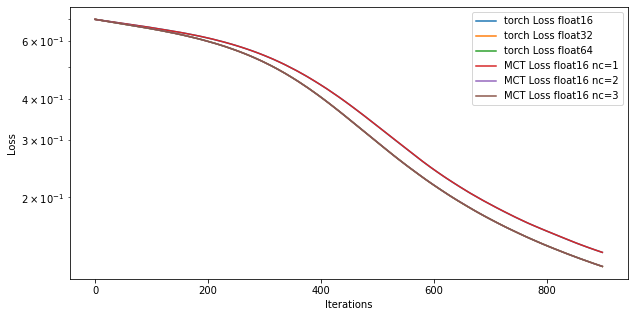

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss16, label="torch Loss float16")
plt.plot(range(epochs), loss32, label="torch Loss float32")
plt.plot(range(epochs), loss64, label="torch Loss float64")
plt.plot(range(epochs), loss_nc1, label="MCT Loss float16 nc=1")
plt.plot(range(epochs), loss_nc2, label="MCT Loss float16 nc=2")
plt.plot(range(epochs), loss_nc3, label="MCT Loss float16 nc=3")
plt.xlabel('Iterations')
# plt.xscale('log')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()